In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py

In [3]:
points  = h5py.File('datasets/train.h5', 'r')
dataset = pd.read_csv('datasets/train.csv')

In [10]:
train_df = dataset.iloc[:int(len(dataset)*0.8)]
val_df = dataset.iloc[int(len(dataset)*0.8):]

train_lb = train_df['label']
valid_lb = val_df['label']

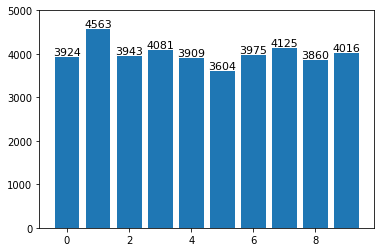

In [11]:
def get_graph(data):
    plt.bar(data.keys(), data.values())
    plt.ylim(0, 5000)

    for cnt, num in data.items():
        plt.text(cnt, num, num,
                fontsize = 11, color = 'black',
                horizontalalignment = 'center',
                verticalalignment   = 'bottom')
        
get_graph(Counter(train_lb))

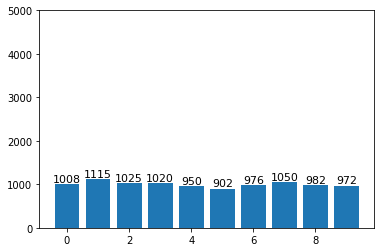

In [12]:
get_graph(Counter(valid_lb))

In [13]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch

/opt/conda/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
EPOCHS        = 30
BATCH_SIZE    = 16
LEARNING_RATE = 1e-4

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
class CustomDataset(Dataset):
    def __init__(self, indexes, labels, points):
        self.indexes = indexes
        self.labels  = labels
        self.points  = points
        
    def __getitem__(self, index):
        
        idx    = self.indexes[index]
        points = self.points[str(idx)][:]
        image  = self.get_vector(points)
    
        if self.labels is not None:
            label = dataset['label'][idx]
            return torch.Tensor(image).unsqueeze(0), label
        
        else:
            return torch.Tensor(image).unsqueeze(0)
        
    def get_vector(self, points, x_y_z = [16, 16, 16]):
        
        xyzmin = np.min(points, axis = 0) - 0.001
        xyzmax = np.max(points, axis = 0) + 0.001
        
        diff   = max(xyzmax-xyzmin) - (xyzmax - xyzmin)
        xyzmin = xyzmin - diff / 2
        xyzmax = xyzmax + diff / 2
        
        segments, shape = [], []
        for i in range(3):
            
            if type(x_y_z[i]) is not int: raise TypeError(f'x_y_z[{i}] must be int')
            
            s, step = np.linspace(xyzmin[i], xyzmax[i], num = (x_y_z[i] + 1), retstep = True)
            segments.append(s)
            shape.append(step)
        
        n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        n_x      = x_y_z[0]
        n_y      = x_y_z[1]
        n_z      = x_y_z[2]
        
        structure = np.zeros((len(points), 4), dtype = int)
        structure[:,0] = np.searchsorted(segments[0], points[:,0]) - 1
        structure[:,1] = np.searchsorted(segments[1], points[:,1]) - 1
        structure[:,2] = np.searchsorted(segments[2], points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * n_x) + structure[:,0]) + (structure[:,2] * (n_x * n_y))
        
        vector = np.zeros(n_voxels)
        count = np.bincount(structure[:,3])
        vector[:len(count)] = count

        vector = vector.reshape(n_z, n_y, n_x)
        return vector

    def __len__(self):
        return len(self.indexes)

In [41]:
train_dataset = CustomDataset(train_df['ID'].values, train_df['label'].values, points)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df['ID'].values, val_df['label'].values, points)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [17]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel,self).__init__()
        self.feature_extract = nn.Sequential(
            nn.Conv3d(1,8,3),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8,32,3),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(4),
            nn.Conv3d(32,128,3),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(32, 10)
                            )

    def forward(self,x):
        x = self.feature_extract(x)
        x = x.view(x.size()[0],-1)
        x = self.classifier(x)
        return x

In [42]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = []
        for data, label in train_loader:
            data, label = data.float().to(device), label.long().to(device)
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        if scheduler is not None:
            scheduler.step()
            
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss)}] Val Loss : [{val_loss}] Val ACC : [{val_acc}]')
        
        if best_score < val_acc:
            best_score = val_acc
            torch.save(model.state_dict(), './best_model.pth')

In [19]:
def validation(model, criterion, val_loader, device):
    model.eval()
    true_labels = []
    model_preds = []
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(val_loader)):
            data, label = data.float().to(device), label.long().to(device)
            
            model_pred = model(data)
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
    
    return np.mean(val_loss), accuracy_score(true_labels, model_preds)

In [43]:
model = BaseModel()
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
scheduler = None

train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 625/625 [00:38<00:00, 16.15it/s]


Epoch : [1] Train Loss : [0.9742746017754078] Val Loss : [0.2223844178944826] Val ACC : [0.9324]


100%|██████████| 625/625 [00:38<00:00, 16.07it/s]


Epoch : [2] Train Loss : [0.30570546485073863] Val Loss : [0.15608274803329258] Val ACC : [0.9527]


100%|██████████| 625/625 [00:38<00:00, 16.23it/s]


Epoch : [3] Train Loss : [0.19921654621912166] Val Loss : [0.11671418849704787] Val ACC : [0.965]


100%|██████████| 625/625 [00:39<00:00, 15.85it/s]


Epoch : [4] Train Loss : [0.15007107796666677] Val Loss : [0.09965064402590505] Val ACC : [0.9736]


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


Epoch : [5] Train Loss : [0.11854231607437832] Val Loss : [0.10088497928084107] Val ACC : [0.972]


100%|██████████| 625/625 [00:38<00:00, 16.13it/s]


Epoch : [6] Train Loss : [0.10227000968698412] Val Loss : [0.09339812996753026] Val ACC : [0.9747]


100%|██████████| 625/625 [00:38<00:00, 16.04it/s]


Epoch : [7] Train Loss : [0.08550131280935021] Val Loss : [0.09638116193697788] Val ACC : [0.9747]


100%|██████████| 625/625 [00:38<00:00, 16.07it/s]


Epoch : [8] Train Loss : [0.07418274303161307] Val Loss : [0.09017019735547364] Val ACC : [0.978]


100%|██████████| 625/625 [00:38<00:00, 16.16it/s]


Epoch : [9] Train Loss : [0.061490485828252346] Val Loss : [0.10277918177419251] Val ACC : [0.9779]


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


Epoch : [10] Train Loss : [0.050235766110879196] Val Loss : [0.09643353964279668] Val ACC : [0.9786]


100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


Epoch : [11] Train Loss : [0.04698612677420096] Val Loss : [0.09866471939594684] Val ACC : [0.9787]


100%|██████████| 625/625 [00:38<00:00, 16.12it/s]


Epoch : [12] Train Loss : [0.042602504862202246] Val Loss : [0.10638690334593193] Val ACC : [0.9774]


100%|██████████| 625/625 [00:38<00:00, 16.03it/s]


Epoch : [13] Train Loss : [0.03500280712177791] Val Loss : [0.10803611990630298] Val ACC : [0.9806]


100%|██████████| 625/625 [00:38<00:00, 16.17it/s]


Epoch : [14] Train Loss : [0.032607020401913635] Val Loss : [0.11692542631004887] Val ACC : [0.9768]


100%|██████████| 625/625 [00:39<00:00, 15.81it/s]


Epoch : [15] Train Loss : [0.028992525454173666] Val Loss : [0.1137693561090414] Val ACC : [0.9783]


100%|██████████| 625/625 [00:39<00:00, 15.94it/s]


Epoch : [16] Train Loss : [0.026112085358975787] Val Loss : [0.1211759643241762] Val ACC : [0.9785]


100%|██████████| 625/625 [00:38<00:00, 16.05it/s]


Epoch : [17] Train Loss : [0.02240712201522376] Val Loss : [0.13753253890354913] Val ACC : [0.978]


100%|██████████| 625/625 [00:38<00:00, 16.08it/s]


Epoch : [18] Train Loss : [0.021230535404236424] Val Loss : [0.1371668899551816] Val ACC : [0.977]


100%|██████████| 625/625 [00:39<00:00, 15.86it/s]


Epoch : [19] Train Loss : [0.021830233565570414] Val Loss : [0.13751289419014825] Val ACC : [0.9795]


100%|██████████| 625/625 [00:39<00:00, 15.81it/s]


Epoch : [20] Train Loss : [0.01950306455333371] Val Loss : [0.14030100687026442] Val ACC : [0.977]


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


Epoch : [21] Train Loss : [0.01653069171112895] Val Loss : [0.13115523913124555] Val ACC : [0.9798]


100%|██████████| 625/625 [00:38<00:00, 16.07it/s]


Epoch : [22] Train Loss : [0.016285538473709043] Val Loss : [0.13633347319130248] Val ACC : [0.9808]


100%|██████████| 625/625 [00:39<00:00, 15.85it/s]


Epoch : [23] Train Loss : [0.016299761750373513] Val Loss : [0.12857682993959502] Val ACC : [0.9811]


100%|██████████| 625/625 [00:39<00:00, 15.91it/s]


Epoch : [24] Train Loss : [0.01560225643285495] Val Loss : [0.13259504256917104] Val ACC : [0.9774]


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


Epoch : [25] Train Loss : [0.014003959466953122] Val Loss : [0.15179655827463007] Val ACC : [0.9791]


100%|██████████| 625/625 [00:39<00:00, 15.84it/s]


Epoch : [26] Train Loss : [0.01270710749938573] Val Loss : [0.14248375583053416] Val ACC : [0.9805]


100%|██████████| 625/625 [00:38<00:00, 16.12it/s]


Epoch : [27] Train Loss : [0.014909268187025506] Val Loss : [0.15494314304135778] Val ACC : [0.9783]


100%|██████████| 625/625 [00:38<00:00, 16.09it/s]


Epoch : [28] Train Loss : [0.012480351082040698] Val Loss : [0.17346102358778254] Val ACC : [0.9759]


100%|██████████| 625/625 [00:39<00:00, 15.90it/s]


Epoch : [29] Train Loss : [0.012166660542035137] Val Loss : [0.1572348343610171] Val ACC : [0.9784]


100%|██████████| 625/625 [00:39<00:00, 16.02it/s]

Epoch : [30] Train Loss : [0.012196324776049795] Val Loss : [0.15280620229821457] Val ACC : [0.9793]


In [44]:
test_df = pd.read_csv('datasets/sample_submission.csv')
test_points = h5py.File('datasets/test.h5', 'r')

In [45]:
test_dataset = CustomDataset(test_df['ID'].values, None, test_points)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [46]:
checkpoint = torch.load('./best_model.pth')
model = BaseModel()
model.load_state_dict(checkpoint)
model.eval()

BaseModel(
  (feature_extract): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [47]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    model_preds = []
    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            data = data.float().to(device)
            
            batch_pred = model(data)
            
            model_preds += batch_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [48]:
preds = predict(model, test_loader, device)

100%|██████████| 2500/2500 [03:16<00:00, 12.73it/s]


In [49]:
test_df['label'] = preds
test_df.to_csv('submit/submit.csv', index=False)